In [1]:
!pip install --upgrade pip
!pip install tensorflow

^C
Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/python3/bin/pip", line 11, in <module>
    sys.exit(main())
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pip/_internal/cli/main.py", line 73, in main
    command = create_command(cmd_name, isolated=("--isolated" in cmd_args))
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pip/_internal/commands/__init__.py", line 96, in create_command
    module = importlib.import_module(module_path)
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.6/importlib/__init__.py", line 126, in import_module
    return _bootstrap._gcd_import(name[level:], package, level)
  File "<frozen importlib._bootstrap>", line 994, in _gcd_import
  File "<frozen importlib._bootstrap>", line 971, in _find_and_load
  File "<frozen importlib._bootstrap>", line 955, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 665, in _load_unlocked
  File "<frozen importlib._b

In [117]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from scipy import stats

import tensorflow as tf
keras = tf.keras


In [118]:
caiso = pd.read_csv('data/caiso_master.csv')
caiso.drop('Unnamed: 0', axis=1, inplace=True)
caiso['INTERVAL_START_PT'] = pd.to_datetime(caiso['INTERVAL_START_PT']).apply(lambda x: x.replace(tzinfo=None))
caiso['INTERVAL_END_PT'] = pd.to_datetime(caiso['INTERVAL_END_PT']).apply(lambda x: x.replace(tzinfo=None))
caiso['date_hour_start'] = pd.to_datetime(caiso['date_hour_start']).apply(lambda x: x.replace(tzinfo=None))
caiso['OPR_DT_PT'] = pd.to_datetime(caiso['OPR_DT_PT']).apply(lambda x: x.replace(tzinfo=None))

caiso.set_index('INTERVAL_START_PT', inplace=True)

caiso.rename({'HH_$_million_BTU_not_seasonal_adj': 'HH_$_mill_BTU', 'total_mw':'total_gen'},axis=1, inplace=True)
caiso['HH_$_mill_BTU'] = pd.to_numeric(caiso['HH_$_mill_BTU'])

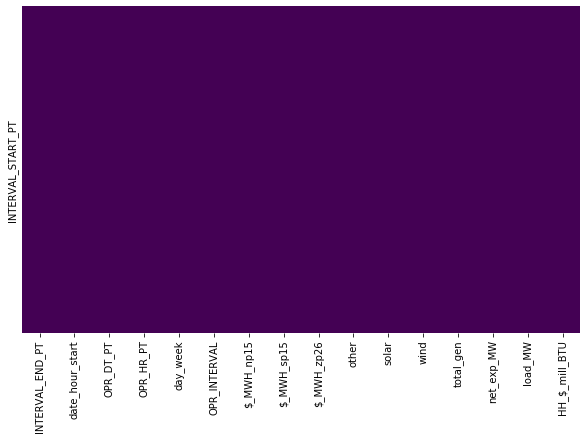

In [119]:
plt.figure(figsize=(10,6))
sns.heatmap(caiso.isnull(), yticklabels=False, cbar=False, cmap='viridis')

---
# Data Processing

In [84]:
one_week_idx = len(caiso) - len(caiso[caiso['OPR_DT_PT'] >= '2020-05-24'])
two_week_idx = len(caiso) - len(caiso[caiso['OPR_DT_PT'] >= '2020-05-17'])
one_month_idx = len(caiso) - len(caiso[caiso['OPR_DT_PT'] >= '2020-05-01'])
two_month_idx = len(caiso) - len(caiso[caiso['OPR_DT_PT'] >= '2020-04-01'])

trn_tst_splt = one_week_idx
train_df = caiso.iloc[:trn_tst_splt, :]
test_df = caiso.iloc[trn_tst_splt:, :]

# Train set
np15_lmp_train = train_df['$_MWH_np15'].values
sp15_lmp_train = train_df['$_MWH_sp15'].values
zp26_lmp_train = train_df['$_MWH_zp26'].values
exog_train = train_df[['day_week', 'other', 'solar', 'wind', 'total_gen', 'net_exp_MW','load_MW', 'HH_$_mill_BTU']].values
train_dates = train_df.index.to_period('H')

# test set
np15_lmp_test = test_df['$_MWH_np15'].values
sp15_lmp_test = test_df['$_MWH_sp15'].values
zp26_lmp_test = test_df['$_MWH_zp26'].values
exog_test = test_df[['day_week', 'other', 'solar', 'wind','total_gen', 'net_exp_MW','load_MW', 'HH_$_mill_BTU']].values
test_dates = test_df.index.to_period('H')

n_period_fcst = len(test_dates)

# Use lists:
all_train_lmp = [np15_lmp_train, sp15_lmp_train, zp26_lmp_train]
all_test_lmp = [np15_lmp_test, sp15_lmp_test, zp26_lmp_test]

allocation_check = len(train_df) + len(test_df) == len(caiso)
print("Dataset allocation check: ", allocation_check)

Dataset allocation check:  True


In [120]:
len(caiso)

11519

---
# LSTM

Gating allows the net decide when to remember the current input and forget it for future inputs. 

The way Keras LSTM layers work is by taking in a numpy array of 3 dimensions (N, W, F) where N is the number of training sequences, W is the sequence length and F is the number of features of each sequence. I chose to go with a sequence length (read window size) of 50 which allows for the network so get glimpses of the shape of the sin wave at each sequence and hence will hopefully teach itself to build up a pattern of the sequences based on the prior window received.

In [140]:
def windowize_data(data, n_prev):
    n_predictions = len(data) - n_prev
    y = data[n_prev:]
    # this might be too clever
    indices = np.arange(n_prev) + np.arange(n_predictions)[:, None]
    x = data[indices, None]
    return x, y

def split_and_windowize(data, n_prev, fraction_test=0.3):
    n_predictions = len(data) - 2*n_prev
    
    n_test  = int(fraction_test * n_predictions)
    n_train = n_predictions - n_test   
    
    x_train, y_train = windowize_data(data[:n_train], n_prev)
    x_test, y_test = windowize_data(data[n_train:], n_prev)
    return x_train, x_test, y_train, y_test

def calc_rmse(actual, pred):
    return np.sqrt(mean_squared_error(actual, pred))

In [127]:
dataset = caiso['$_MWH_np15'].values

# Determines window
batch_size = 24 * 7
train_test_allocation = batch_size / len(dataset)

X1_train, X1_test, y1_train, y1_test = split_and_windowize(dataset, batch_size, train_test_allocation)
X1_train.shape, X1_test.shape, y1_train.shape, y1_test.shape

((10852, 168, 1), (331, 168, 1), (10852,), (331,))

In [137]:
n_features = X1_train.shape[2]

lstm_endo = keras.Sequential()
lstm_endo.add(keras.layers.LSTM(32, input_shape=(batch_size, n_features), return_sequences=True))
lstm_endo.add(keras.layers.LSTM(32, return_sequences=False))
lstm_endo.add(keras.layers.Dense(1, activation='linear'))
lstm_endo.compile(optimizer='adam',loss='mse')

In [138]:
lstm_endo.summary()

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_19 (LSTM)               (None, 168, 32)           4352      
_________________________________________________________________
lstm_20 (LSTM)               (None, 32)                8320      
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 33        
Total params: 12,705
Trainable params: 12,705
Non-trainable params: 0
_________________________________________________________________


In [139]:
lstm_endo.fit(X1_train, y1_train, batch_size, epochs=20)

Epoch 1/20
65/65 [==============================] - 10s 156ms/step - loss: 1294.3300
Epoch 2/20
65/65 [==============================] - 10s 156ms/step - loss: 1016.4171
Epoch 3/20
65/65 [==============================] - 10s 156ms/step - loss: 900.7401
Epoch 4/20
65/65 [==============================] - 10s 156ms/step - loss: 813.1495
Epoch 5/20
65/65 [==============================] - 10s 156ms/step - loss: 738.1512
Epoch 6/20
65/65 [==============================] - 10s 156ms/step - loss: 673.8982
Epoch 7/20
65/65 [==============================] - 10s 155ms/step - loss: 619.0300
Epoch 8/20
65/65 [==============================] - 10s 156ms/step - loss: 572.2670
Epoch 9/20
65/65 [==============================] - 10s 155ms/step - loss: 531.8978
Epoch 10/20
65/65 [==============================] - 10s 155ms/step - loss: 497.4225
Epoch 11/20
65/65 [==============================] - 10s 156ms/step - loss: 466.9777
Epoch 12/20
65/65 [==============================] - 10s 155ms/step - lo

In [142]:
y1_pred = lstm_endo.predict(X1_test)
np_rmse_endo = calc_rmse(y1_test, y1_pred)
print("RMSE - NP15 LSTM - Endo {:.5}".format(np_rsme_endo))

NameError: name 'mean_squared_error' is not defined

In [103]:
fig, ax = plt.subplots(figsize=(12,6))
ax.plot()

8

((11351, 8, 1), (168, 8, 1), (11351,), (168,))

((10852, 168, 1, 6), (331, 168, 1, 6), (10852, 6), (331, 6))